In [53]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            (operating_income / ((total_assets  + total_liabilities) * num_beds)) as roe,
            gross_revenue,
            year,
            ownership,
            ((total_debt / (total_assets + total_liabilities) * num_beds)) as debt_to_equity_ratio,
            tot_fund_balance,
            current_ratio,
            quick_ratio,
            pct_fixed_assets,
            pct_other_assets,
            (tot_days / tot_bed_days_avail) as fill_rate,
            cash,
            chow_last_12mos,
            region,
            state,
            state_lean,
            county_ssa,
            zip,
            tot_discharge_tot,
            def_score,
            fine_tot,
            fine_cnt,
            resfamcouncil,
            sprinkler_status,
            overall_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            snf_avg_stay_len_title_tot,
            pop_over_70,
            over_70_pct,
            has_outpatient,
            bedcert,
            fac_type,
            staff_style,
            totlichrd_to_tot
            
            
        FROM Master
        WHERE 
            roa > -1 
            AND roa < 1 
            AND total_assets > 0
            AND total_liabilities > 0 
            AND operating_income < 15000000 
            AND operating_income > -15000000
            AND gross_revenue < 300000000
            AND operating_income < 300000000
            AND (operating_income / ((total_assets  + total_liabilities) * num_beds)) < 1
            AND (operating_income / ((total_assets  + total_liabilities) * num_beds)) > -1
            AND snf_avg_stay_len_title_tot < 100
            
        ORDER BY prov_id; 
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

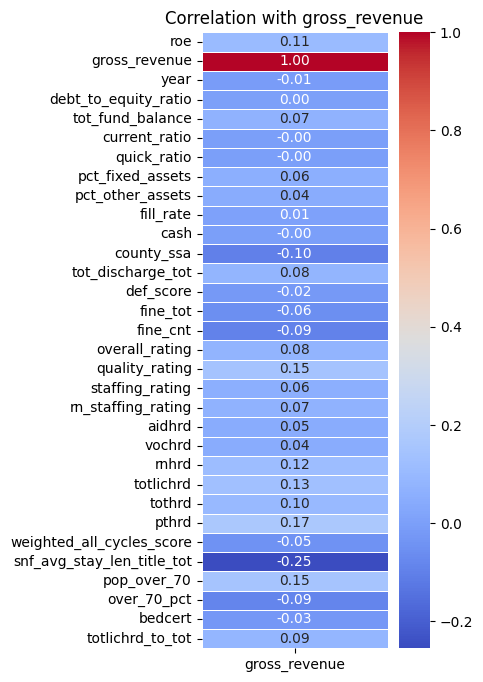

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'operating income' is the name of your y variable
y_variable = 'gross_revenue'

# Concatenate y and X along the columns axis
data = df.select_dtypes(include=['number'])

# Remove 0 columns
non_zero_columns = data.columns[(data != 0).any()]
data = data[non_zero_columns]

# Compute the correlation matrix
correlation_matrix = data.corr()

# Filter correlations with the y variable
y_correlation = correlation_matrix[y_variable]

# Plot heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(y_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation with {y_variable}')
plt.show()

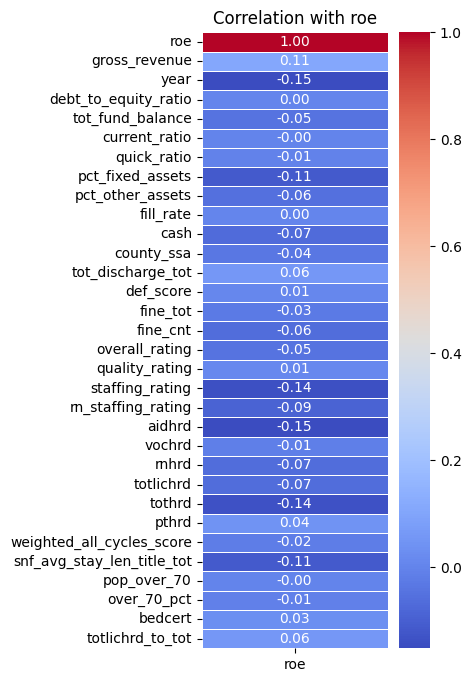

In [55]:
# Assuming 'operating income' is the name of your y variable
y_variable = 'roe'

# Concatenate y and X along the columns axis
data = df.select_dtypes(include=['number'])

# Remove 0 columns
non_zero_columns = data.columns[(data != 0).any()]
data = data[non_zero_columns]

# Compute the correlation matrix
correlation_matrix = data.corr()

# Filter correlations with the y variable
y_correlation = correlation_matrix[y_variable]

# Plot heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(y_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation with {y_variable}')
plt.show()

In [56]:
from sklearn.preprocessing import MinMaxScaler


y = pd.DataFrame()
y['gr'] = df['gross_revenue']
y['roe'] = df['roe']

df = df.drop(columns=['gross_revenue','roe'])

# Initialize the scaler
scaler = MinMaxScaler()

# Select numerical columns
quant_cols = df.select_dtypes(include=['number']).columns

# Apply scaling only to the selected numerical columns
df[quant_cols] = scaler.fit_transform(df[quant_cols])

In [57]:
from sklearn.model_selection import train_test_split

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Set X
X = df_encoded

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=84)

In [58]:
import xgboost as xgb

# Define XGBoost regressor and set hyperparameters
gr_model = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=30000,      # Iterations of the model
    learning_rate=0.00925,    # Speed at which the learners optimize
    max_depth=3,            # Depth of the weak learners
    min_child_weight=1,
    device = 'cuda',
    subsample=0.85,
    seed=717,
    colsample_bytree=0.95,
    random_state=42,
    early_stopping_rounds=500,
    eval_metric='rmse',
    objective='reg:squarederror',
    gamma=0.8,              # Increasing this value will make model more conservative
    reg_alpha=0.8,           # Increasing this value will make model more conservative
    reg_lambda=0.8          # Increasing this value will make model more conservative
)

# Train the model with progress printout and early stopping
gr_model.fit(
    X_train, y_train['gr'],
    eval_set=[(X_train, y_train['gr']), (X_test, y_test['gr'])],  # Evaluation set for tracking progress
    verbose=1000
)

[0]	validation_0-rmse:10091365.87678	validation_1-rmse:10306403.12890
[1000]	validation_0-rmse:4834201.85570	validation_1-rmse:5240924.05775
[2000]	validation_0-rmse:4194968.21571	validation_1-rmse:4683227.27303
[3000]	validation_0-rmse:3867711.04664	validation_1-rmse:4423067.06156
[4000]	validation_0-rmse:3645919.47724	validation_1-rmse:4250544.62222
[5000]	validation_0-rmse:3486576.35757	validation_1-rmse:4131451.05608
[6000]	validation_0-rmse:3353940.92537	validation_1-rmse:4038064.73207
[7000]	validation_0-rmse:3240868.55536	validation_1-rmse:3954658.78554
[8000]	validation_0-rmse:3144790.87803	validation_1-rmse:3886017.91912
[9000]	validation_0-rmse:3057233.10529	validation_1-rmse:3824433.51808
[10000]	validation_0-rmse:2979755.69173	validation_1-rmse:3775874.30222
[11000]	validation_0-rmse:2910840.46874	validation_1-rmse:3733412.44687
[12000]	validation_0-rmse:2844501.63984	validation_1-rmse:3695124.05352
[13000]	validation_0-rmse:2784522.27495	validation_1-rmse:3661124.02717
[14

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device='cuda', early_stopping_rounds=500,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.8, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.00925, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Text(0.5, 1.0, 'XGBoost Learning Curve with rmse')

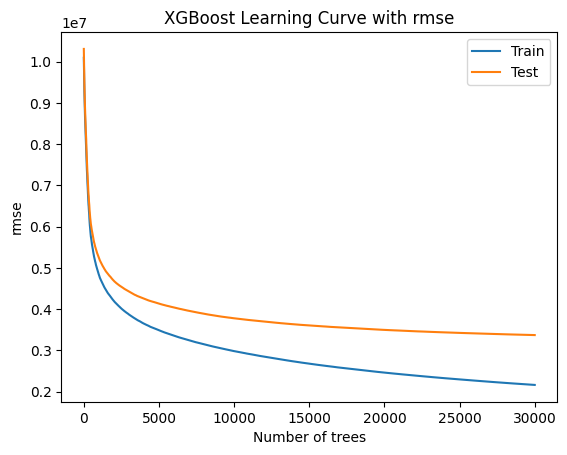

In [59]:
# Get the evaluation results
results = gr_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot the learning curve with RSME
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('rmse')
plt.title('XGBoost Learning Curve with rmse')

In [60]:
from sklearn.metrics import r2_score, median_absolute_error

# Predict on test set
y_pred_gr = gr_model.predict(X_test)

# Median absolute error
mdae = median_absolute_error(y_test['gr'], y_pred_gr)
print("Median absolute error: {:.2f}".format(mdae))

# R² Score (Coefficient of Determination)
r2gr = r2_score(y_test['gr'], y_pred_gr)
print("R² Score (Coefficient of Determination): {:.5f}".format(r2gr))

Median absolute error: 1201119.75
R² Score (Coefficient of Determination): 0.89370


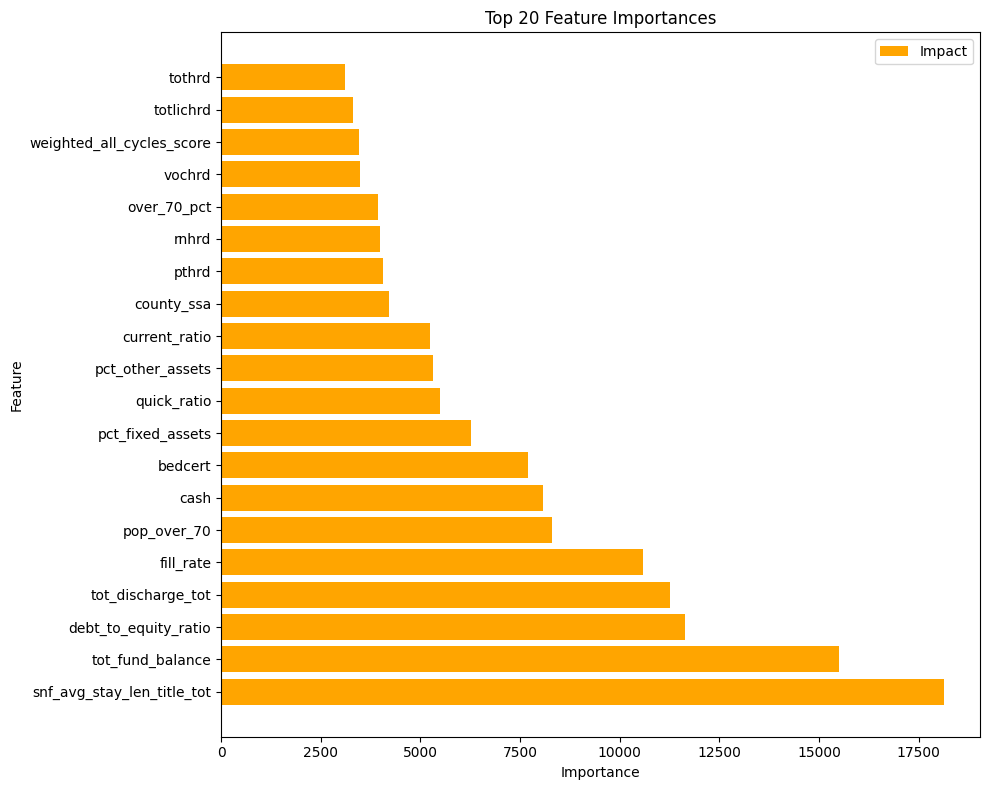

In [61]:
# Get feature importances based on gain
feature_importances  = gr_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances  = dict(sorted_feature_importance)

# Extract feature names and importances
positive_features , positive_importances = zip(*positive_importances.items())

# Select only the top 20 features
top_features  = positive_features [:20]
top_importances  = positive_importances [:20]

# Plot positive importances based on gain for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features , top_importances , color='orange', label='Impact')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

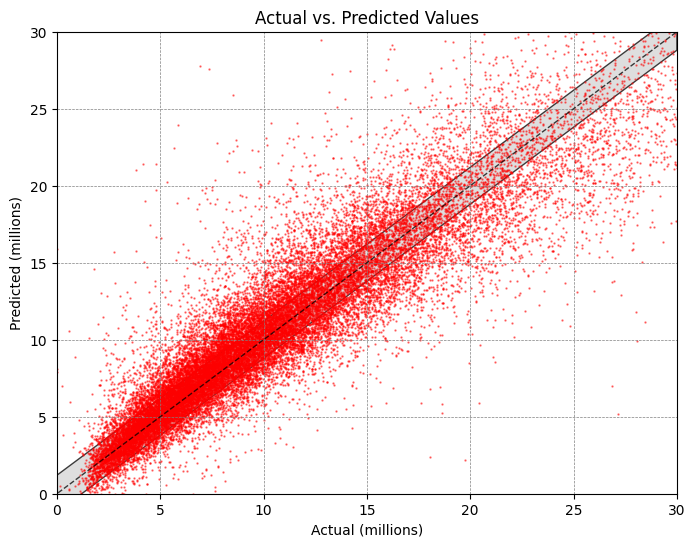

In [62]:
import numpy as np

# Convert values to millions
y_test_millions = y_test['gr'] / 1000000
y_pred_millions = y_pred_gr / 1000000
median_absolute_error_millions = mdae / 1000000

# Calculate residuals
residuals = y_pred_millions - y_test_millions

color = ['red']

plt.figure(figsize=(8, 6))

# Plot the shaded region with darker edges
x = np.linspace(-30, 30, 100)
y1 = x + median_absolute_error_millions
y2 = x - median_absolute_error_millions
plt.fill_between(x, y1, y2, color='lightgray', edgecolor='black', linewidth=1, alpha= .75)

plt.scatter(y_test_millions, y_pred_millions, c=color, alpha=0.5, s=0.5)

# Calculate the 95th percentile of actual and predicted values
y_test_95th_percentile = np.percentile(y_test_millions, 95)
y_pred_95th_percentile = np.percentile(y_pred_millions, 95)

# Plot the diagonal line
plt.plot([-30,30], [-30,30], 'k--', lw=1, alpha=0.75) 



plt.xlabel('Actual (millions)')
plt.ylabel('Predicted (millions)')
plt.title('Actual vs. Predicted Values')

# Set axis limits to show the 95th percentile values
plt.xlim(left=0, right=30)
plt.ylim(bottom=0, top=30)

# Add light gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [63]:
import shap

explainer = shap.Explainer(gr_model)
shap_values = explainer.shap_values(X_train, check_additivity=False)

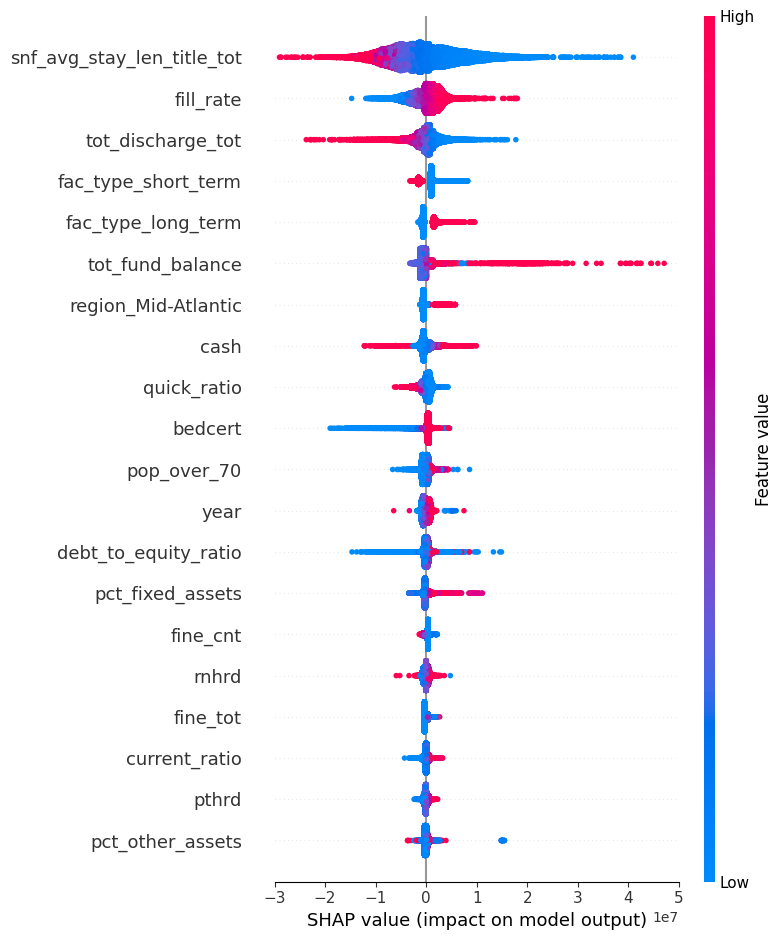

In [64]:
# Find the indices of the top 20 features in the original feature set
top_feature_indices = [X_train.columns.tolist().index(feature) for feature in top_features]

# Select the SHAP values corresponding to the top 20 features
top_shap_values = shap_values[:, top_feature_indices]

# Select only the top 20 features from the training data
top_X_train = X_train.iloc[:, top_feature_indices]

# Calculate shap_values
fig = shap.summary_plot(shap_values, X_train, show=False)
plt.xlim([-30000000, 50000000])  # Set x-axis limit
plt.show()

In [65]:
# Create a new DataFrame with the predictions
y_pred_df = pd.DataFrame({'gr': y_pred_gr}, index=X_test.index)

# Join the predictions DataFrame with X_test
X_test = X_test.join(y_pred_df)
y_test = y_test['roe']

def bin_income(data):
    if data >= np.percentile(y_test, 66):
        return '2'
    if data >= data >= np.percentile(y_test, 33):
        return '1'
    else:
        return '0'
    
y_test = y_test.apply(bin_income)

In [66]:
from sklearn.preprocessing import LabelEncoder

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=84)

# Convert class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Define XGBoost classifier and set hyperparameters for multiclass classification
roe_model = xgb.XGBClassifier(
    booster='gbtree',
    seed=1001,
    n_estimators=10000,          # Iterations of the model
    learning_rate=0.0535,         # Speed at which the learners optimize
    max_depth=3,                # Depth of the weak learners
    min_child_weight=1, 
    device = 'cuda',    
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='merror',         # Multiclass logloss for evaluation
    objective='multi:softprob',  # Use softmax for multiclass classification
    num_class=4,                # Number of classes in your dataset
    gamma=0.4,                 # Increasing this value will make model more conservative
    reg_alpha=0.49,             # Increasing this value will make model more conservative
    reg_lambda=0.5,            # Increasing this value will make model more conservative
    early_stopping_rounds=2500
)

# Train the model with progress printout
roe_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
    verbose=500                                       # Print progress
)

[0]	validation_0-merror:0.44994	validation_1-merror:0.45714
[500]	validation_0-merror:0.30254	validation_1-merror:0.37268
[1000]	validation_0-merror:0.25304	validation_1-merror:0.36498
[1500]	validation_0-merror:0.21303	validation_1-merror:0.36129
[2000]	validation_0-merror:0.17664	validation_1-merror:0.35786
[2500]	validation_0-merror:0.14879	validation_1-merror:0.35836
[3000]	validation_0-merror:0.12429	validation_1-merror:0.35535
[3500]	validation_0-merror:0.10369	validation_1-merror:0.35434
[4000]	validation_0-merror:0.08584	validation_1-merror:0.35334
[4500]	validation_0-merror:0.07205	validation_1-merror:0.35334
[5000]	validation_0-merror:0.06200	validation_1-merror:0.35535
[5500]	validation_0-merror:0.05391	validation_1-merror:0.35493
[6000]	validation_0-merror:0.04839	validation_1-merror:0.35501
[6500]	validation_0-merror:0.04303	validation_1-merror:0.35635
[6551]	validation_0-merror:0.04236	validation_1-merror:0.35627


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device='cuda', early_stopping_rounds=2500,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0535, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

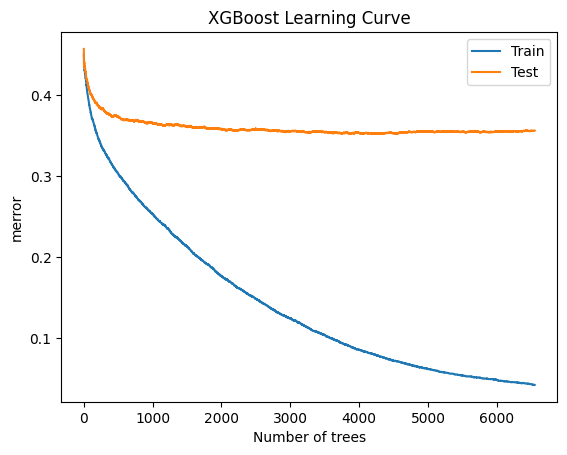

In [67]:
# Get the evaluation results
results = roe_model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# Plot the learning curve with multi-logloss
plt.plot(x_axis, results['validation_0']['merror'], label='Train')
plt.plot(x_axis, results['validation_1']['merror'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('merror')
plt.title('XGBoost Learning Curve')
plt.show()

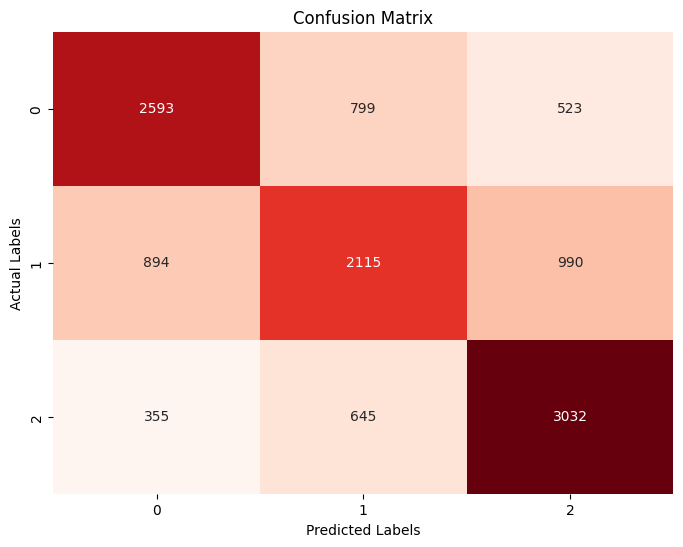

In [68]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = roe_model.predict(X_test)
y_pred_proba = roe_model.predict_proba(X_test)[:, 1]  

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [72]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calculate ROC curves and AUC scores for each class
num_classes = len(np.unique(y_test))
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc='lower right')
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x800 with 0 Axes>

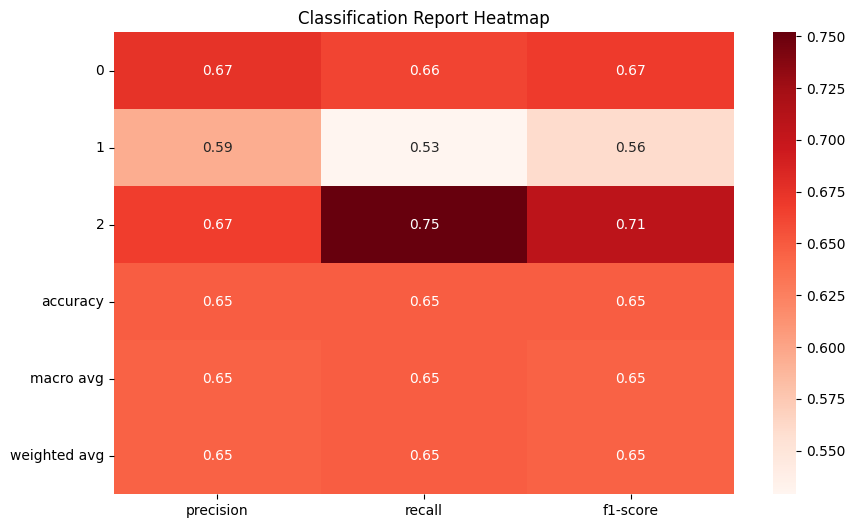

In [69]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a pandas DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.drop(['support'], axis=1), annot=True, cmap='Reds', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

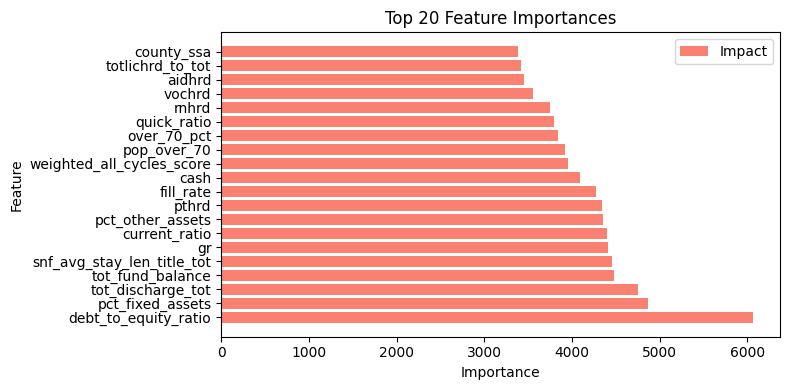

In [73]:
import matplotlib.pyplot as plt

# Get feature importances based on gain
feature_importances  = roe_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances  = dict(sorted_feature_importance)

# Extract feature names and importances
positive_features , positive_importances = zip(*positive_importances.items())

# Select only the top 20 features
top_features  = positive_features [:20]
top_importances  = positive_importances [:20]

# Plot positive importances based on gain for top 20 features
plt.figure(figsize=(8, 4))
plt.barh(top_features , top_importances , color='salmon', label='Impact')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

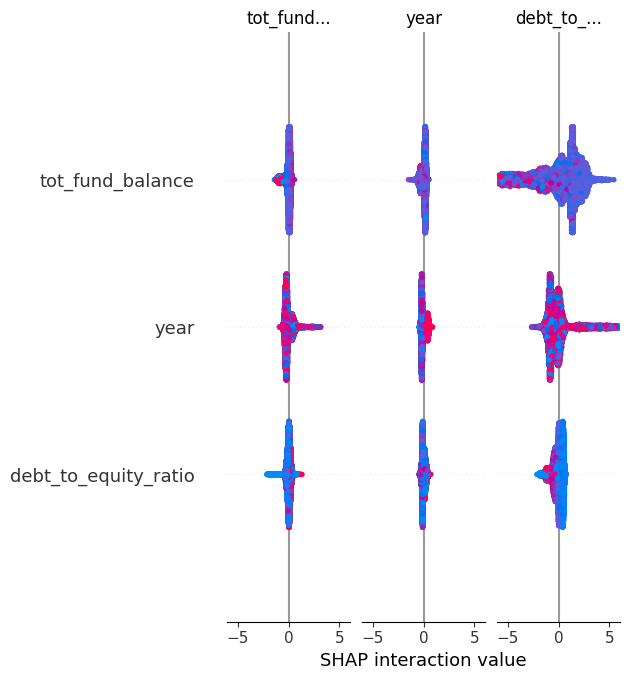

In [71]:

explainer = shap.Explainer(roe_model)
shap_values = explainer.shap_values(X_train, check_additivity=False)

# Plot summary plot
shap.summary_plot(shap_values, X_train, class_names=[0,1,2], show=False)
plt.show()